# Static tuning

In [1]:
%cd ..

D:\Projects\Python\Euro-NeurIPS-2022


In [2]:
import glob
import itertools

import pandas as pd
from scipy import stats
import tomli

import tools

In [3]:
def res2data(where: str):
    with open(where, "r") as fh:
        data = fh.readlines()

    seed = int(where.split("-")[-1].removesuffix(".txt"))
    data = data[3:-5]  # remove headers and aggregate rows
    rows = [datum.strip().split() for datum in data]
    return [
        (inst, seed, int(cost), int(iters), tools.name2size(inst))
        for inst, feas, cost, iters, _ in rows
        if feas == "Y"
    ]

def size2group(size: int):
    if size < 300:
        return "small"
    elif 300 <= size <= 500:
        return "medium"
    else:
        return "large"

def read(group: str, exp: int):
    instances = glob.glob(f"data/tune/{group}/res-{exp}-*.txt")
    records = itertools.chain.from_iterable([res2data(inst) for inst in instances])

    df = pd.DataFrame(records, columns=["instance", "seed", "cost", "iters", "size"])
    df["size_group"] = df["size"].apply(size2group)
    df["exp"] = exp

    with open(f"data/tune/{group}/{exp}.toml", "rb") as fh:
        static_config = tomli.load(fh)

    for param, value in static_config["static"]["params"].items():
        df[param] = value
    
    return df

## Penalty parameters

In [4]:
dfs = [read("penalty", exp) for exp in range(1, 101)]
df = pd.concat(dfs)
df.head()

,instance,seed,cost,iters,size,size_group,exp,initialTimeWarpPenalty,nbPenaltyManagement,feasBooster,penaltyIncrease,penaltyDecrease,targetFeasible,repairProbability,repairBooster
0,ORTEC-VRPTW-ASYM-a9d4edc2-d1-n200-k15,1,146875,74832,200,small,1,1,100,2.0,1.2,0.85,0.4,50,10
1,ORTEC-VRPTW-ASYM-ef7dad5e-d1-n200-k12,1,123845,61663,200,small,1,1,100,2.0,1.2,0.85,0.4,50,10
2,ORTEC-VRPTW-ASYM-9016f313-d1-n200-k20,1,174610,75016,200,small,1,1,100,2.0,1.2,0.85,0.4,50,10
3,ORTEC-VRPTW-ASYM-fd32ebe8-d1-n201-k15,1,127563,45584,201,small,1,1,100,2.0,1.2,0.85,0.4,50,10
4,ORTEC-VRPTW-ASYM-8512fc31-d1-n201-k20,1,158456,64635,201,small,1,1,100,2.0,1.2,0.85,0.4,50,10


In [5]:
fields = [
    "initialTimeWarpPenalty",
    "nbPenaltyManagement",
    "feasBooster",
    "penaltyIncrease",
    "penaltyDecrease",
    "targetFeasible",
    "repairProbability",
    "repairBooster",    
]

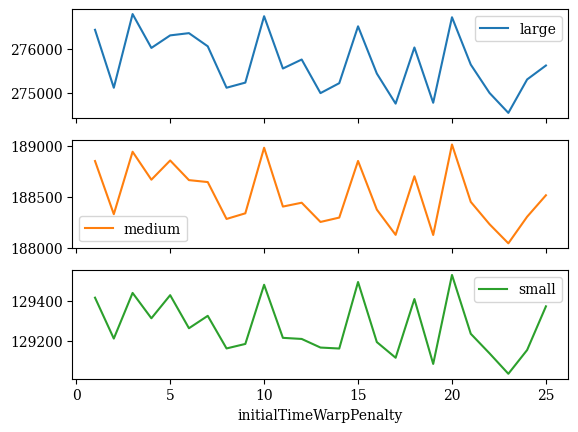

In [6]:
df.cost.groupby([df["initialTimeWarpPenalty"], df["size_group"]]).mean().unstack().plot(subplots=True);

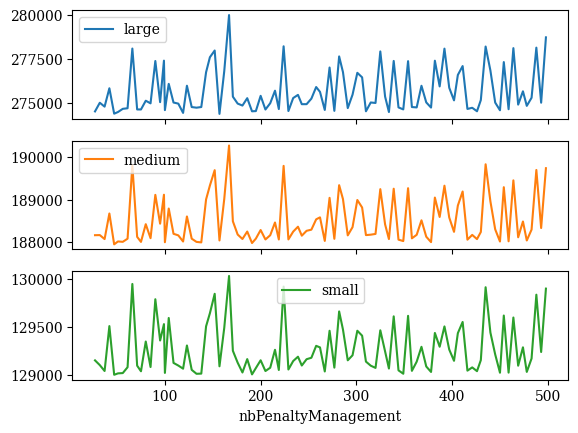

In [7]:
df.cost.groupby([df["nbPenaltyManagement"], df["size_group"]]).mean().unstack().plot(subplots=True);

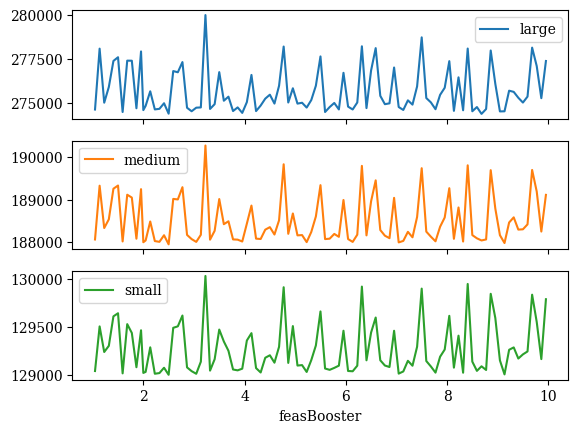

In [8]:
df.cost.groupby([df["feasBooster"], df["size_group"]]).mean().unstack().plot(subplots=True);

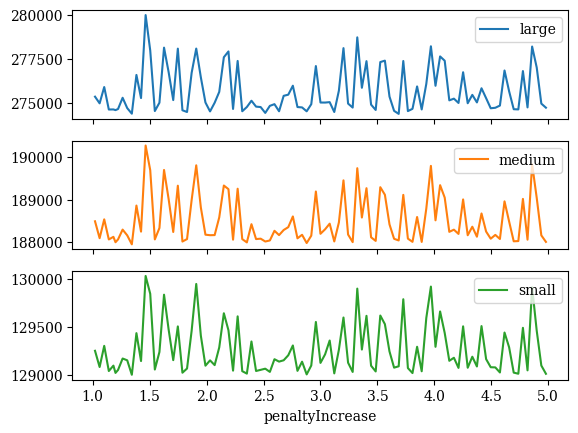

In [9]:
df.cost.groupby([df["penaltyIncrease"], df["size_group"]]).mean().unstack().plot(subplots=True);

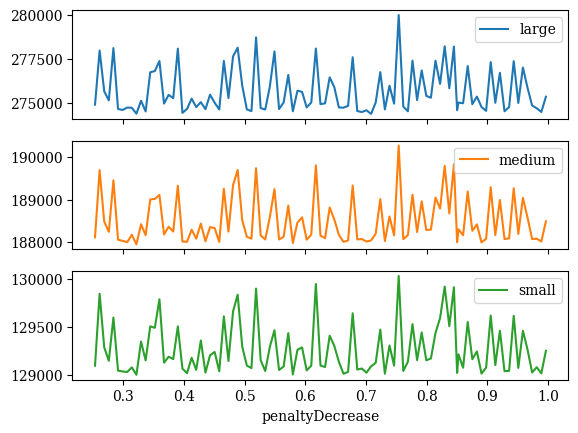

In [10]:
df.cost.groupby([df["penaltyDecrease"], df["size_group"]]).mean().unstack().plot(subplots=True);

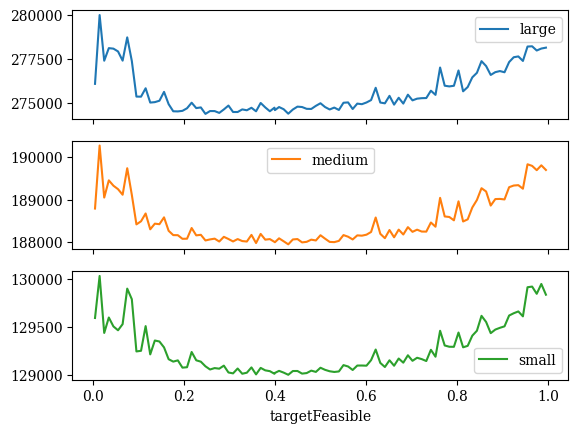

In [11]:
df.cost.groupby([df["targetFeasible"], df["size_group"]]).mean().unstack().plot(subplots=True);

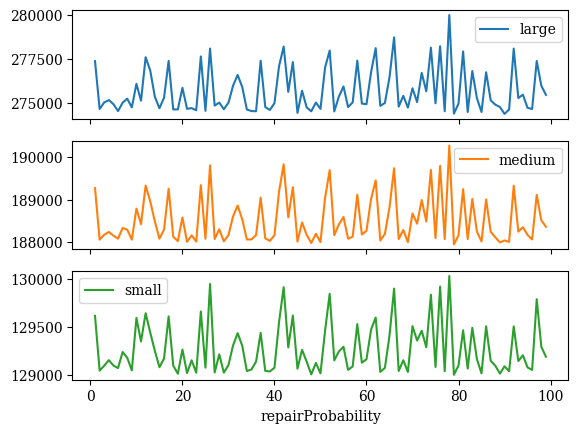

In [12]:
df.cost.groupby([df["repairProbability"], df["size_group"]]).mean().unstack().plot(subplots=True);

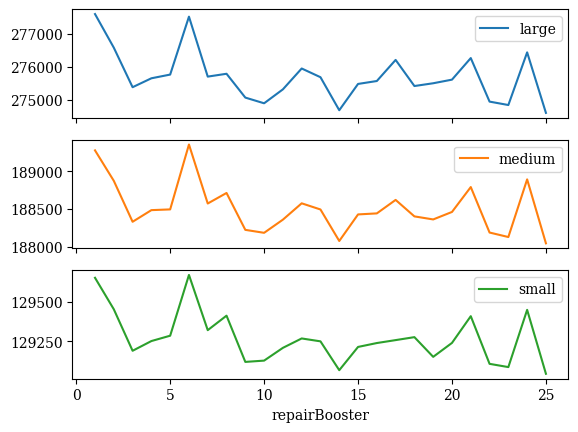

In [13]:
df.cost.groupby([df["repairBooster"], df["size_group"]]).mean().unstack().plot(subplots=True);

Is there any significant improvement?

In [14]:
mean_value = 164_315  # from a recent benchmark on main

for exp in range(1, 101):
    data = df[df.exp == exp]
    test = stats.ttest_1samp(data.cost, mean_value, alternative='less')
    mean = data.cost.mean()

    if mean < mean_value:
        print(f"{exp:>3}  {test.pvalue:.2f}  {mean:.0f}")

 50  0.49  164288
 83  0.50  164311


So no: not really. Only two experiments are slightly better than the default on main, but the effect is nowhere near significant. 

Could we do better with separate configurations for each group size, rather than one size fits all?

In [15]:
best_per_group = []

for size in ["small", "medium", "large"]:
    grouped = df[df.size_group == size].groupby("exp").cost.mean()
    num_size = len(df[df.size_group == size]) / 1_000
    best_per_group.append((num_size, grouped.min()))

total = len(df) / 1_000
print(sum(num * val for num, val in best_per_group) / total)

164287.04979919677


No, not really. So the setting of scenario 50 seems best for all instances.

## Population parameters